In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install tensorflow==2.0.0-beta0

In [ ]:
import tensorflow as tf
tf.__version__

In [ ]:
cd /content/drive/My Drive/AI content/RCNN-master

In [ ]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [ ]:
!unzip Airplanes_Annotations.zip
!unzip Images.zip
# /content/Airplanes_Annotations.zip
# path = "/content/drive/My Drive/AI content/RCNN-master/Images"
# annot = "/content/drive/My Drive/AI content/RCNN-master/Airplanes_Annotations"
path = "/content/Images"
annot = "/content/Airplanes_Annotations"

Archive:  Airplanes_Annotations.zip
  inflating: Airplanes_Annotations/42845.csv  
  inflating: Airplanes_Annotations/428451.csv  
 extracting: Airplanes_Annotations/428452.csv  
  inflating: Airplanes_Annotations/428461.csv  
 extracting: Airplanes_Annotations/428462.csv  
 extracting: Airplanes_Annotations/42847.csv  
  inflating: Airplanes_Annotations/428472.csv  
 extracting: Airplanes_Annotations/42848.csv  
 extracting: Airplanes_Annotations/428481.csv  
  inflating: Airplanes_Annotations/428482.csv  
  inflating: Airplanes_Annotations/428483.csv  
  inflating: Airplanes_Annotations/42849.csv  
  inflating: Airplanes_Annotations/428491.csv  
 extracting: Airplanes_Annotations/428492.csv  
  inflating: Airplanes_Annotations/42850.csv  
 extracting: Airplanes_Annotations/428501.csv  
 extracting: Airplanes_Annotations/428503.csv  
  inflating: Airplanes_Annotations/airplane_001.csv  
  inflating: Airplanes_Annotations/airplane_002.csv  
 extracting: Airplanes_Annotations/airplane_0

Our airplane dataset contains two parts   
1) Image part-> Contain pictures of airplanes   
2) Airplanes_Annotations-> Contain information about bounding boxes for the pictures available.     
The next cell will show you an example of a labelled image in the dataset. Feel free to change the value of `Index` below and re-run to see different examples.

airplane_148.jpg


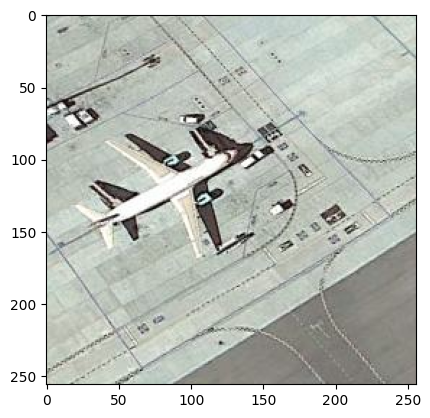

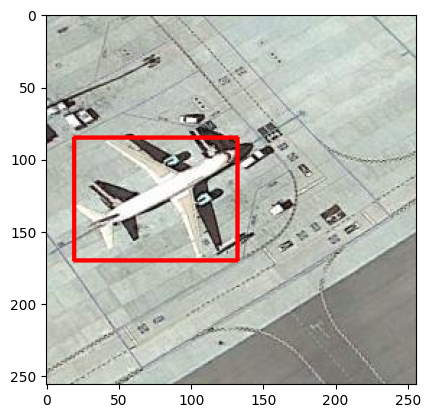

In [ ]:
        Index=148
        filename = "airplane_"+str(Index)+".jpg"
        print(filename)
        img = cv2.imread(os.path.join(path,filename))
        df = pd.read_csv(os.path.join(annot,filename.replace(".jpg",".csv")))
        plt.imshow(img)
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
        plt.figure()
        plt.imshow(img)

In [ ]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

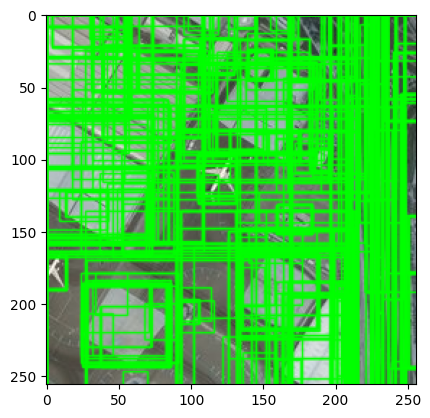

In [ ]:
im = cv2.imread(os.path.join(path,"42850.jpg"))
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
#     print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)

In [ ]:
def get_iou(bb1, bb2):
  # assuring for proper dimension.
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
  # calculating dimension of common area between these two boxes.
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
  # if there is no overlap output 0 as intersection area is zero.
    if x_right < x_left or y_bottom < y_top:
        return 0.0
  # calculating intersection area.
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
  # individual areas of both these bounding boxes.
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
  # union area = area of bb1_+ area of bb2 - intersection of bb1 and bb2.
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [ ]:
# At the end of below code we will have our train data in these lists
train_images=[]
train_labels=[]

In [ ]:
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)   # setting given image as base image
            ss.switchToSelectiveSearchFast()     # running selective search on bae image
            ssresults = ss.process()     # processing to get the outputs
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:     # till 2000 to get top 2000 regions only
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})  # calculating IoU for each of the proposed regions
                        if counter < 30:       # getting only 30 psoitive examples
                            if iou > 0.70:     # IoU or being positive is 0.7
                                timage = imout[x:x+w,y:y+h]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1              # to insure we have collected all psotive examples
                        if falsecounter <30:      # 30 negatve examples are allowed only
                            if iou < 0.3:         # IoU or being negative is 0.3
                                timage = imout[x:x+w,y:y+h]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1             #to ensure we have collected all negative examples
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1        # to signal the complition of data extaction from a particular image
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

0 airplane_065.jpg
1 airplane_117.jpg
2 airplane_020.jpg
3 airplane_178.jpg
4 airplane_007.jpg
inside
5 airplane_196.jpg
7 airplane_043.jpg
8 airplane_152.jpg
9 airplane_028.jpg
10 airplane_179.jpg
11 airplane_105.jpg
12 airplane_053.jpg
inside
13 airplane_122.jpg
14 airplane_155.jpg
15 airplane_051.jpg
16 airplane_061.jpg
17 airplane_160.jpg
18 airplane_086.jpg
19 airplane_069.jpg
20 airplane_035.jpg
21 airplane_071.jpg
22 airplane_011.jpg
23 airplane_185.jpg
24 airplane_087.jpg
25 airplane_067.jpg
26 airplane_102.jpg
27 airplane_066.jpg
28 airplane_029.jpg
29 airplane_195.jpg
30 airplane_173.jpg
31 airplane_092.jpg
32 airplane_064.jpg
33 airplane_118.jpg
34 airplane_079.jpg
35 airplane_019.jpg
36 airplane_165.jpg
37 airplane_084.jpg
39 airplane_005.jpg
inside
40 airplane_040.jpg
41 airplane_162.jpg
42 airplane_082.jpg
43 airplane_187.jpg
44 airplane_059.jpg
45 airplane_174.jpg
46 airplane_095.jpg
47 airplane_116.jpg
48 airplane_097.jpg
inside
49 airplane_032.jpg
50 airplane_111.jpg
5

In [ ]:
# conversion of train data into arrays for further training
X_new = np.array(train_images)
Y_new = np.array(train_labels)

In [ ]:
from keras.layers import Dense
from keras import Model
from keras import optimizers

In [ ]:
vgg = tf.keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
for layer in vgg.layers[:-2]:
  layer.trainable = False
x = vgg.get_layer('fc2')
last_output =  x.output
x = tf.keras.layers.Dense(1,activation = 'sigmoid')(last_output)
model = tf.keras.Model(vgg.input,x)
model.compile(optimizer = "adam",
              loss = 'binary_crossentropy',
              metrics = ['acc'])



553467096/553467096 [==============================] - 6s 0us/step


In [ ]:
# model.summary()
model.fit(X_new,Y_new,batch_size = 64,epochs = 3, verbose = 1,validation_split=.05,shuffle = True)

Epoch 1/3
133/133 [==============================] - 70s 423ms/step - loss: 1.2581 - acc: 0.8052 - val_loss: 0.3955 - val_acc: 0.8386
Epoch 2/3
133/133 [==============================] - 36s 271ms/step - loss: 0.2995 - acc: 0.8704 - val_loss: 0.4213 - val_acc: 0.8094
Epoch 3/3
133/133 [==============================] - 37s 279ms/step - loss: 0.2386 - acc: 0.9028 - val_loss: 0.4678 - val_acc: 0.8274


In [ ]:
svm_image = [];
svm_label = [];

In [ ]:
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
                timage = image[x1:x2,y1:y2]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                svm_image.append(resized)
                svm_label.append([0,1])
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if falsecounter <5:
                            if iou < 0.3:
                                timage = imout[x:x+w,y:y+h]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                svm_image.append(resized)
                                svm_label.append([1,0])
                                falsecounter += 1
                        else :
                            flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

0 airplane_065.jpg
1 airplane_117.jpg
2 airplane_020.jpg
3 airplane_178.jpg
4 airplane_007.jpg
5 airplane_196.jpg
7 airplane_043.jpg
8 airplane_152.jpg
9 airplane_028.jpg
10 airplane_179.jpg
11 airplane_105.jpg
12 airplane_053.jpg
13 airplane_122.jpg
14 airplane_155.jpg
15 airplane_051.jpg
16 airplane_061.jpg
17 airplane_160.jpg
18 airplane_086.jpg
19 airplane_069.jpg
20 airplane_035.jpg
21 airplane_071.jpg
22 airplane_011.jpg
23 airplane_185.jpg
24 airplane_087.jpg
25 airplane_067.jpg
26 airplane_102.jpg
27 airplane_066.jpg
28 airplane_029.jpg
29 airplane_195.jpg
30 airplane_173.jpg
31 airplane_092.jpg
32 airplane_064.jpg
33 airplane_118.jpg
34 airplane_079.jpg
35 airplane_019.jpg
36 airplane_165.jpg
37 airplane_084.jpg
39 airplane_005.jpg
40 airplane_040.jpg
41 airplane_162.jpg
42 airplane_082.jpg
43 airplane_187.jpg
44 airplane_059.jpg
45 airplane_174.jpg
46 airplane_095.jpg
47 airplane_116.jpg
48 airplane_097.jpg
49 airplane_032.jpg
50 airplane_111.jpg
51 airplane_068.jpg
52 airpla

**SVM Model Architecture**  
First we removed the last layer of the previous model and then added a Dense layer of 2 units at the end.

Now we will see our new Model Summary and we will train it.

In [ ]:
cd "/content/drive/My Drive/AI content/RCNN-master"

/content/drive/My Drive/AI content/RCNN-master


In [ ]:
#adding svm to last layer
x =model.get_layer('fc2').output
Y = tf.keras.layers.Dense(2)(x)
final_model = tf.keras.Model(model.input,Y)
final_model.compile(loss='hinge',
              optimizer='adam',
              metrics=['accuracy'])
final_model.summary()
final_model.load_weights('my_model_weights.h5')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'my_model_weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
hist_final = final_model.fit(np.array(svm_image),np.array(svm_label),batch_size=32,epochs = 20,verbose = 1,shuffle = True,validation_split = 0.05)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist_final.history['loss'])
plt.plot(hist_final.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

In [ ]:
image = cv2.imread(os.path.join(path,'airplane_020.jpg'))
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()

imOut = image.copy()
boxes = []
count = 0
for e,result in enumerate(ssresults):
  if e < 50:
    x,y,w,h = result
    timage = imout[x:x+w,y:y+h]
    resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
    resized = np.expand_dims(resized,axis = 0)
    out = final_model.predict(resized)
    print(e,out)
    if(out[0][0]<out[0][1]):
      boxes.append([x,y,w,h])
      count+=1

for box in boxes:
    x, y, w, h = box
    print(x,y,w,h)
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.imshow(imOut)